In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import statsmodels.api as sm
from PyEMD import EMD
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [20]:
FORECAST_STEPS = 75
ticker = "^IXIC"
data = yf.download(ticker, start="2019-09-20", end="2023-09-20")
adj_close = data['Adj Close'].to_numpy()

[*********************100%%**********************]  1 of 1 completed


In [21]:
emd = EMD()
eIMFs = emd(adj_close)

In [22]:
# series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [23]:
def apply_arima(data, order, forecast_steps):
    data = data.tolist()
    size = int(len(data) - forecast_steps*2)
    train = data[:size]
    test = data[size:]
    history = [x for x in train]
    forecasts = []
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        forecasts.append(yhat)
        obs = test[t]
        history.append(obs)
    return forecasts

eIMFs_arima_WEIGHT_TUNING = []
eIMFs_arima_FORECASTING = []
for eimf in eIMFs:
    forecast = apply_arima(eimf, order=(1,1,0), forecast_steps=FORECAST_STEPS)
    eIMFs_arima_WEIGHT_TUNING.append(forecast[:-FORECAST_STEPS])
    eIMFs_arima_FORECASTING.append(forecast[-FORECAST_STEPS:])


C:\Users\aron9\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [24]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x.view(len(x), -1, 1), (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out

In [25]:
# train and test
eIMFs_lstm_WEIGHT_TUNING = []
eIMFs_lstm_FORECASTING = []
for data in eIMFs:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    reframed = series_to_supervised(scaled_data, 1, 1)
    
    train = reframed[:-(FORECAST_STEPS*2)]
    test = reframed[-(FORECAST_STEPS*2):]

    train_X, train_y = torch.FloatTensor(train[:, :-1]), torch.FloatTensor(train[:, -1])
    test_X, test_y = torch.FloatTensor(test[:, :-1]), torch.FloatTensor(test[:, -1])
    
    model = LSTMModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    
    # train
    num_epochs = 5000
    for epoch in range(num_epochs):
        outputs = model(train_X)
        outputs = outputs.squeeze()
        optimizer.zero_grad()
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
    
    # forecasting (test)
    with torch.no_grad():
        test_outputs = model(test_X)
        test_outputs = scaler.inverse_transform(test_outputs.numpy())
    eIMFs_lstm_WEIGHT_TUNING.append(test_outputs[:-FORECAST_STEPS])
    eIMFs_lstm_FORECASTING.append(test_outputs[-FORECAST_STEPS:])

In [26]:
# back from IMFs
lstm_WEIGHT_TUNING = np.sum(eIMFs_lstm_WEIGHT_TUNING, axis = 0).squeeze()
arima_WEIGHT_TUNING = np.sum(eIMFs_arima_WEIGHT_TUNING, axis=0).squeeze()

lstm_FORECASTING = np.sum(eIMFs_lstm_FORECASTING, axis = 0).squeeze()
arima_FORECASTING = np.sum(eIMFs_arima_FORECASTING, axis = 0).squeeze()

In [27]:
# weight tuning based on single-models' errors
errors_lstm = lstm_WEIGHT_TUNING - adj_close[-(FORECAST_STEPS*2):-FORECAST_STEPS]
errors_arima = arima_WEIGHT_TUNING - adj_close[-(FORECAST_STEPS*2):-FORECAST_STEPS]

weight_lstm = 1 / np.sqrt((errors_lstm ** 2).mean())
weight_arima = 1 / np.sqrt((errors_arima ** 2).mean())


In [28]:
ensemble_predictions_LSTM_ARIMA = (lstm_FORECASTING * weight_lstm + arima_FORECASTING * weight_arima) / (weight_lstm + weight_arima)

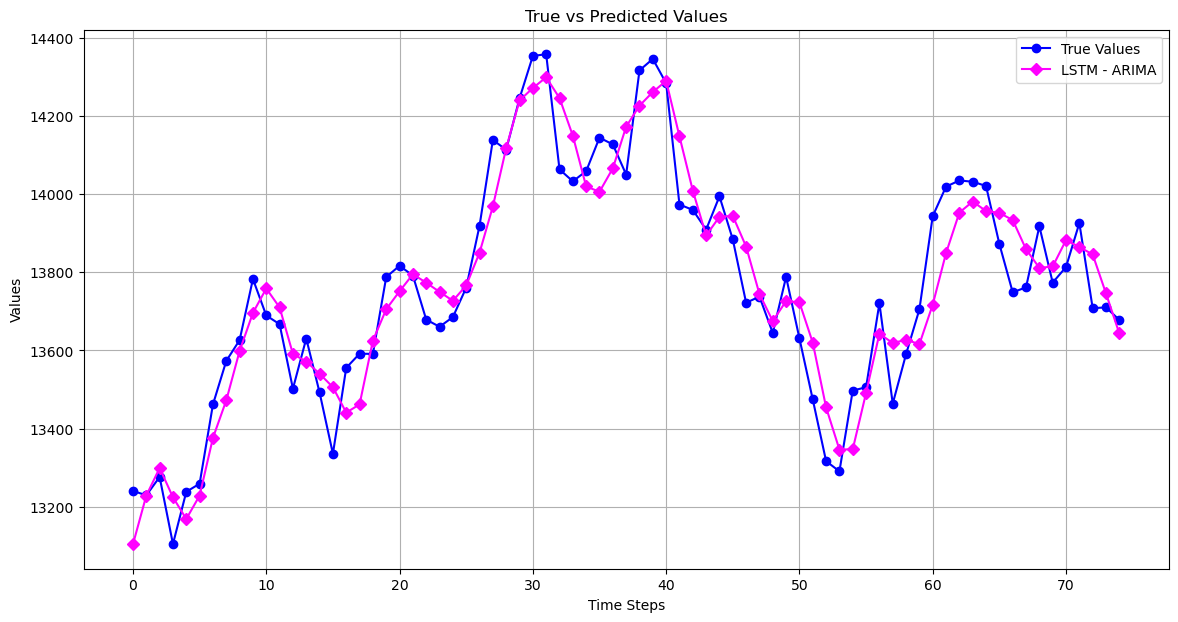

In [33]:
# plot

plt.figure(figsize=(14, 7))
plt.plot(adj_close[-FORECAST_STEPS:], label='True Values', marker='o', color='blue')

#plt.plot(lstm_FORECASTING, label='LSTM Values', marker='^', color='orange')
plt.plot(ensemble_predictions_LSTM_ARIMA, label='LSTM - ARIMA', marker='D', color='magenta')
#plt.plot(arima_FORECASTING, label='ARIMA', marker='*', color='black')

plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
ensemble_errors_LSTM_ARIMA = ensemble_predictions_LSTM_ARIMA - adj_close[-FORECAST_STEPS:]
# metrics for model evaluation:

rmse_ensemble_LSTM_ARIMA = np.sqrt((ensemble_errors_LSTM_ARIMA ** 2).mean())
rmse_lstm = np.sqrt((errors_lstm ** 2).mean())
rmse_arima = np.sqrt((errors_arima ** 2).mean())
print("RMSE LSTM-ARIMA: ", rmse_ensemble_LSTM_ARIMA)
print("RMSE LSTM: ", rmse_lstm)
print("RMSE ARIMA: ", rmse_arima)
print()

mae_arima = np.abs(errors_arima).mean()
mae_lstm = np.abs(errors_lstm).mean()
mae_ensemble_LSTM_ARIMA = np.abs(ensemble_errors_LSTM_ARIMA).mean()
print("MAE LSTM-ARIMA: ", mae_ensemble_LSTM_ARIMA)
print("MAE LSTM: ", mae_lstm)
print("MAE ARIMA: ", mae_arima)
print()

mape_lstm = (np.abs(errors_lstm / adj_close[-FORECAST_STEPS:]) * 100).mean()
mape_arima = (np.abs(errors_arima / adj_close[-FORECAST_STEPS:]) * 100).mean()
mape_ensemble_LSTM_ARIMA = (np.abs(ensemble_errors_LSTM_ARIMA / adj_close[-FORECAST_STEPS:]) * 100).mean()
print("MAPE LSTM-ARIMA: ", mape_ensemble_LSTM_ARIMA)
print("MAPE LSTM: ", mape_lstm)
print("MAPE ARIMA: ", mape_arima)


RMSE LSTM-ARIMA:  95.63767451458462
RMSE LSTM:  105.93295514597604
RMSE ARIMA:  111.3235597788134

MAE LSTM-ARIMA:  80.51310874608312
MAE LSTM:  84.37845052083334
MAE ARIMA:  90.44928898904385

MAPE LSTM-ARIMA:  0.5853023678616875
MAPE LSTM:  0.6161491418413167
MAPE ARIMA:  0.658447651103864


In [31]:
cash = 100000
initial_cash = cash
positions = 0  # This can represent shares of an ETF or contracts of a future
previous_index_price = adj_close[-FORECAST_STEPS - 1]  # Initialize with the last price before the forecasting period
cashiii = []
for yhat, y in zip(ensemble_predictions_LSTM_ARIMA, adj_close[-FORECAST_STEPS:]):
    
    # Use the previous day's closing price to determine the trading action
    if yhat > previous_index_price:
        positions_to_take = cash // previous_index_price  
        cash -= positions_to_take * previous_index_price
        
        # Liquidate the position at the end of the day (current day's closing price)
        positions += positions_to_take
        cash += positions * y
        positions = 0
        
        # If prediction is lower than previous day's closing price, short sell
    elif yhat < previous_index_price:
        # Short sell based on the previous day's closing price
        positions_to_short = cash // previous_index_price
        cash += positions_to_short * previous_index_price
        positions -= positions_to_short  # Negative positions represent a short

        # Cover the short at the end of the day (current day's closing price)
        cash += positions * y  # Since positions are negative, this results in buying to cover the short
        positions = 0
    cashiii.append(cash)
    previous_index_price = y  # Update the previous index price for the next iteration

# Calculate final portfolio value based on the last available price
portfolio_value = cash + (positions * previous_index_price)
#print(portfolio_value)

percentage_gain = ((portfolio_value - initial_cash) / initial_cash) * 100
print(f"Percentage Gain: {percentage_gain:.2f}%")

Percentage Gain: 52.63%


In [32]:
initial_value = adj_close[-FORECAST_STEPS]  # First forecasted value
final_value = adj_close[-1]  # Last forecasted value
print(initial_value)
print(final_value)
percentage_gain_buy_and_hold = ((final_value - initial_value) / initial_value) * 100
print(f"Percentage Gain (Buy and Hold): {percentage_gain_buy_and_hold:.2f}%")


13240.76953125
13678.1904296875
Percentage Gain (Buy and Hold): 3.30%
